# Estimating Price Elasticity of Orange Juice Demand

### Summary of Contents:
1. [Data](#data)
2. [A Gentle Start: Naive ML](#naive)
3. [Parametric Heterogeneity: Double Machine Learning](#dml)
4. [Nonparametric Heterogeneity: Orthogonal Random Forest](#orf)

**Important:** This notebook provides some room for experimentation in solving this problem. If you are looking for the end-to-end solution, look for the same file name with the "Complete" suffix added.

# 1. Data <a class="anchor" id="data"></a>

We use Dominick’s dataset, [a popular historical dataset](https://www.chicagobooth.edu/research/kilts/datasets/dominicks) of store-level orange juice prices and sales provided by University of Chicago Booth School of Business. 

<img src="https://upload.wikimedia.org/wikipedia/commons/f/fd/Orange_juice_1.jpg" width=250px/>

The dataset has ~29,000 observations and includes the store level, weekly prices and sales of 3 different brands of orange juice over 7 years in Chicago area. The dataset also contains 17 continuous and categorical variables that encode store-level customer information such as the age, log income, education level, etc, as well as brand information. We define the following variables:

* Y: Orange Juice sales (log)
* T: Price (log)
* X: Income (feature of heterogeneity)
* W: Store-level features (education, age, etc.)
* $\theta(X)$: Effect of price on sales (Orange juice elasticity)

The goal is to learn the elasticity of orange juice as a function of income in the presence of high-dimensional controls. Thus, we model the world as follows:
$$
\begin{align}
Y & = \theta(X) \cdot T + f(W) + \epsilon\\
T &= g(W) + \eta
\end{align}
$$
where $\epsilon, \eta$ are uncorrelated error terms.

In [1]:
# Helper imports
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.request 
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, \
                                 MultiTaskElasticNet, MultiTaskElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels.api as sm

# EconML imports
from econml.bootstrap import BootstrapEstimator
from econml.dml import DMLCateEstimator, SparseLinearDMLCateEstimator
from econml.ortho_forest import ContinuousTreatmentOrthoForest, WeightedModelWrapper
from econml.utilities import cross_product

%matplotlib inline

In [2]:
# Import the data
file_name = "oj_large.csv"

if not os.path.isfile(file_name):
    print("Downloading file (this might take a few seconds)...")
    urllib.request.urlretrieve("https://msalicedatapublic.blob.core.windows.net/datasets/OrangeJuice/oj_large.csv", file_name)
oj_data = pd.read_csv(file_name)

## 1.1 Data Exploration

In [3]:
oj_data.head()

,store,brand,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,2,tropicana,40,9.018695,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
1,2,tropicana,46,8.723231,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
2,2,tropicana,47,8.253228,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
3,2,tropicana,48,8.987197,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
4,2,tropicana,50,9.093357,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927


In [4]:
oj_data.shape

(28947, 17)

Text(0.5,1,'Demand vs price of OJ for different brands')

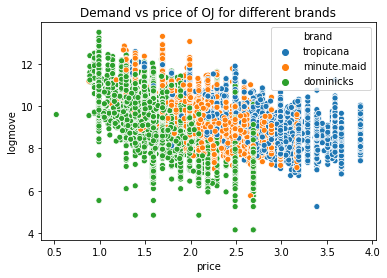

In [5]:
sns.scatterplot(x="price", y="logmove", hue="brand", data=oj_data)
plt.title("Demand vs price of OJ for different brands")

## 1.2 Data Preprocessing

In [6]:
def process_data(data):
    # Prepare data
    Y = data['logmove'].values
    T = np.log(data["price"]).values
    scaler = StandardScaler()
    W1 = scaler.fit_transform(data[[c for c in data.columns if c not in ['price', 'logmove', 'brand', 'week', 'store','INCOME']]].values)
    W2 = pd.get_dummies(data['brand'], drop_first=True).values
    W = np.concatenate([W1, W2], axis=1)
    X = data[['INCOME']].values
    return Y, T, W, X

Y, T, W, X = process_data(oj_data)

In [7]:
## Generate test data
min_income = 10.0 
max_income = 11.1
delta = (max_income - min_income) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1, 1)

# 2. A Gentle Start: Naive ML <a class="anchor" id="naive"></a>

If we didn't know anything about causal inference, we might have tried some standard ML techniques to capture the treatment effect heterogeneity. In this section, we try a naive regression model $Y \sim T$:

$$
\begin{align}
Y &= \theta(X)\cdot T+c + \epsilon \\
\theta(X)&=a+b\cdot X + \eta
\end{align}
$$
where $\epsilon, \eta$ are independent errors.

In [8]:
poly = PolynomialFeatures(1, include_bias=True)
XT = cross_product(poly.fit_transform(X), T)

In [9]:
### DIY section!
# Fit a linear model Y ~ XT. Solution here:

# Calculate predictions for X_test using the coefficients `a` and `b` from the above model.
te_pred = None

In [10]:
# Uncomment to plot results
"""
plt.plot(X_test, te_pred, label="OJ Elasticity")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()
"""

'\nplt.plot(X_test, te_pred, label="OJ Elasticity")\nplt.xlabel(r\'Income\')\nplt.ylabel(\'Orange Juice Elasticity\')\nplt.legend()\nplt.title("Orange Juice Elasticity vs Income")\nplt.show()\n'

Intuitively, we expect higher income populations to be less price-sensitive and hence have larger elasticities. Is this true from the plot above?

In the next section, we apply `econml` estimators to see if we can remedy the issue we encountered before. 

# 3. Parametric Heterogeneity: Double Machine Learning  <a class="anchor" id="dml"></a>

We apply the `DMLCateEstimator` in `econml` package to estimate orange juice price elasticity
as a function of income.

## 3.1 Default setting: Linear heterogeneity

In [11]:
est = DMLCateEstimator(model_y=RandomForestRegressor(n_estimators=100),
                       model_t=RandomForestRegressor(n_estimators=100))
est.fit(Y, T, X, W)
te_pred=est.effect(X_test)

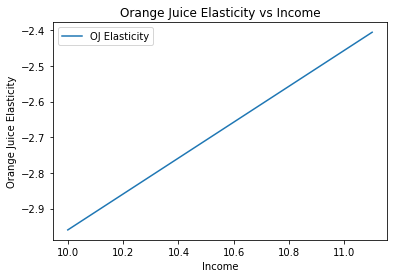

In [12]:
# Plot Orange Juice elasticity as a function of income
plt.plot(X_test, te_pred, label="OJ Elasticity")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

In [13]:
# Boostrap confidence interval
boot_est = BootstrapEstimator(DMLCateEstimator(model_y=RandomForestRegressor(n_estimators=100),
                                               model_t=RandomForestRegressor(n_estimators=100)),
                              n_bootstrap_samples=20)
boot_est.fit(Y, T, X, W)
te_pred_interval = boot_est.effect_interval(X_test, lower=1, upper=99)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


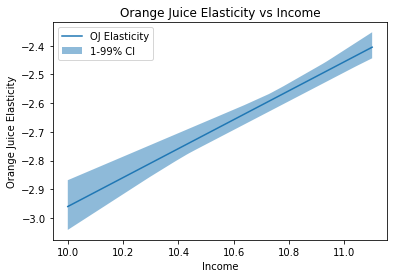

In [14]:
# Plot Orange Juice elasticity as a function of income
plt.plot(X_test.flatten(), te_pred, label="OJ Elasticity")
plt.fill_between(X_test.flatten(), te_pred_interval[0], te_pred_interval[1], alpha=.5, label="1-99% CI")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.title("Orange Juice Elasticity vs Income")
plt.legend()
plt.show()

The estimates look more reasonable now! The slope has an upwards trend and the estimates are in the expected range $(-3, -2)$. Let's see what happens if we add some more structure to $\theta(X)$. 

## 3.2 Polynomial heterogeneity

In this section, we assume a polynomial form for $\theta(X)$.

In [15]:
est = DMLCateEstimator(model_y=RandomForestRegressor(n_estimators=100),
                       model_t=RandomForestRegressor(n_estimators=100),
                       featurizer=PolynomialFeatures(degree=3))
est.fit(Y, T, X, W)
te_pred=est.effect(X_test)

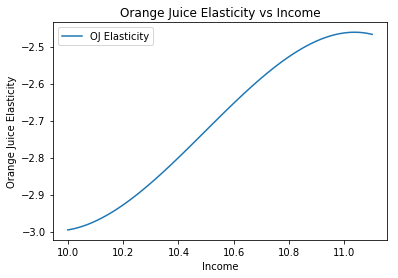

In [16]:
# Plot Orange Juice elasticity as a function of income
plt.plot(X_test, te_pred, label="OJ Elasticity")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

In [17]:
### DIY section!
# Calculate the boostrap confidence intervals using the Bootstrap Estimator
# See section 3.1 for inspiration
te_pred_interval = None

In [18]:
# Uncomment to plot results
"""
plt.plot(X_test.flatten(), te_pred, label="OJ Elasticity")
plt.fill_between(X_test.flatten(), te_pred_interval[0], te_pred_interval[1], alpha=.5, label="1-99% CI")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.title("Orange Juice Elasticity vs Income")
plt.legend()
plt.show()
"""

'\nplt.plot(X_test.flatten(), te_pred, label="OJ Elasticity")\nplt.fill_between(X_test.flatten(), te_pred_interval[0], te_pred_interval[1], alpha=.5, label="1-99% CI")\nplt.xlabel(r\'Income\')\nplt.ylabel(\'Orange Juice Elasticity\')\nplt.title("Orange Juice Elasticity vs Income")\nplt.legend()\nplt.show()\n'

## 3.3 Model Selection

Here we try different polynomial degrees in our final model to compare the model performance. The score of final model can be seen as the proxy of the score of the treatment effect when we don't know the true treatment effect. We can use this function to do model selection or parameter tuning.

In [19]:
X_train, X_test, Y_train, Y_test, \
W_train, W_test, T_train, T_test = train_test_split(X, Y, W, T, test_size=0.3, random_state=42) # 42, the meaning of life

In [20]:
### DIY section!
# Calculate scores for different polynomial featurizations (try polynomial degrees [1,2,3,4,5])
# Hint: the dml estimators have a method `score` that you can call like est.score(Y_test, T_test, X_test, W_test)
score = {}

In [21]:
# Uncomment once you have the scores calculated
"""
score
"""

'\nscore\n'

In [22]:
# Uncomment once you have the scores calculated
"""
print("Best model selected by score: ", min(score, key=lambda x: score.get(x)))
"""

'\nprint("Best model selected by score: ", min(score, key=lambda x: score.get(x)))\n'

# 4. Nonparametric Heterogeneity: Orthogonal Random Forest  <a class="anchor" id="orf"></a>

Double Machine Learning is a great technique if we have some priors on what the treatment effect function should look like. However, if we want a fully non-parametric estimation of the treatment effect, we need to use different tools. 

In this section, we apply the `ContinuousTreatmentOrthoForest` in `econml` to estimate orange juice price elasticity
as a function of income. This is a fully non-parametric model based on Random Forests.

In [23]:
# Define some parameters
n_trees = 500
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.02
bootstrap = False

In [24]:
# Define the estimator
est = ContinuousTreatmentOrthoForest(
        n_trees=n_trees, min_leaf_size=min_leaf_size, max_depth=max_depth, 
        subsample_ratio=subsample_ratio, bootstrap=bootstrap, 
        model_T=Lasso(alpha=0.1),
        model_Y=Lasso(alpha=0.1),
        model_T_final=WeightedModelWrapper(LassoCV(cv=3), sample_type="weighted"), 
        model_Y_final=WeightedModelWrapper(LassoCV(cv=3), sample_type="weighted")
       )

In [25]:
est.fit(Y, T, X, W)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished


In [26]:
min_income = 10.0 
max_income = 11.1
delta = (max_income - min_income) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1, 1)

In [27]:
te_pred = est.effect(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:  2.6min finished


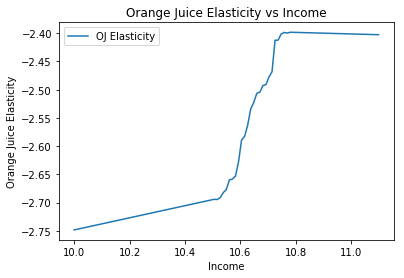

In [28]:
# Plot Orange Juice elasticity as a function of income
plt.plot(X_test.flatten(), te_pred[:, 0], label="OJ Elasticity")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

We note that the treatment effect has an upwards trend, but most of the variation is concentrated in the middle range of the $\log$(INCOME).

We can also use a bootstrap estimator to generate confidence intervals. Since Orthogonal Forests are non-parametric models, we expect the estimates to be less biased, but the variance to increase, i.e. the confidence intervals to be wider. 

**Note:** In order to return results in a few minutes we're limiting the number of trees to 100 and the number of bootstrap samples to 10 in the code below, but for better estimates these numbers can be increased at the cost of increased runtime. We suggest you don't execute the following cells if you are running this notebooks on a resource-constrained machines. 

In [29]:
boot_est = BootstrapEstimator(ContinuousTreatmentOrthoForest(
        n_trees=100, min_leaf_size=min_leaf_size, max_depth=max_depth, 
        subsample_ratio=subsample_ratio, bootstrap=bootstrap, 
        model_T=Lasso(alpha=0.1),
        model_Y=Lasso(alpha=0.1),
        model_T_final=WeightedModelWrapper(LassoCV(cv=3), sample_type="weighted"), 
        model_Y_final=WeightedModelWrapper(LassoCV(cv=3), sample_type="weighted")
       ), n_bootstrap_samples=10, n_jobs=-1)

In [30]:
boot_est.fit(Y, T, X, W)
te_pred_interval = boot_est.effect_interval(X_test, lower=1, upper=99)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: 

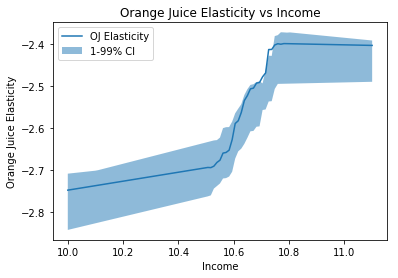

In [31]:
plt.plot(np.ndarray.flatten(X_test), te_pred[:, 0], label="OJ Elasticity")
plt.fill_between(np.ndarray.flatten(X_test), 
                 te_pred_interval[0][:, 0], 
                 te_pred_interval[1][:, 0], alpha=.5, label="1-99% CI")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.title("Orange Juice Elasticity vs Income")
plt.legend()
plt.show()